# Atlas notebooks

> This notebook reproduces some of the common regional figures of the IPCC AR6-WGI Atlas chapter. This and other notebooks are available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purpose.

## Bias adjustment of daily mean, minimum and maximum temperature for climate indices calculation

*29/6/2021*

**A. Casanueva** (Santander Meteorology Group. Dept. Applied Mathematics and Compute Science, University of Cantabria, Santander, Spain).

Bias adjustment is used in the IPCC interactive Atlas for the calculation of absolute threshold-based indices, namely the number of days with daily maximum temperature above 35$^\circ$C (TX35) and above 40$^\circ$C (TX40) and the number of frost days (daily minimum temperature below 0$^\circ$C). More details in bias adjustment can be found in the Cross-Chapter Box 10.2: "Issues in bias adjustment" and Casanueva et al. 2020.

The chosen bias adjustment method is the ISIMIP3 method (Lange 2019). It requires daily mean, minimum and maximum temperature for the adjustment of maximum and minimum temperature, which are obtained from the correction of the amplitude and skewness of the diurnal temperature cycle. In this example, a single global climate model (CMIP5_EC-EARTH_r12i1p1) is bias-adjusted using the W5E5 observational dataset (Cucchi et al. 2020) as reference for the Mediterranean region. We focus on summer months for the calculation of bias-adjusted extreme temperature indices

### Load packages
This notebook is based on the R programming language and requires the climate4R packages:

 * `loadeR` to load climate model and observational datasets (Iturbide et al. 2019).
 * `climate4R.UDG` to access harmonized climate data via the [Santander Met Group User Data Gateway](http://meteo.unican.es/udg-tap/).
 * `transformeR` to manipulate climate data (Iturbide et al. 2019).
 * `downscaleR` to adjust systematic model biases (Bedia et al. 2020).
 * `climate4R.indices` to compute climate indices (Iturbide et al. 2019).
 * `visualizeR` to produce graphical representations of the results (Frías et al. 2018).
 
Along with:

 * `rgdal` to work with spatial data (Bivand et al., 2018).

In [49]:
# install.packages("rgdal")
library(loadeR) 
library(climate4R.UDG) 
library(downscaleR)
library(climate4R.indices)
library(visualizeR)
library(rgdal)

### Parameter settings

Assign parameters to select season, baseline period, future periods and scenario, as well as the names of the datasets to be used: observations and global climate model simulations for the historical and future scenarios.

In [2]:
years.hist <- 1986:2005
years.rcp <- 2041:2060
season <- 6:8

dataset.obs <- "W5E5" 
dataset.hist <- "CMIP5_EC-EARTH_r12i1p1_historical"
dataset.rcp <- "CMIP5_EC-EARTH_r12i1p1_rcp85"

Dataset names are UDG codes for the selected datasets. Check other available harmonized datasets with `?UDG.datasets`

### Prepare IPCC region

For illustrative purposes, this example uses one IPCC region only, namely the Mediterranean (MED) region. See the specific notebook ([reference-regions_R.ipynb](reference-regions_R.ipynb)) for more details on how to work with IPCC regions (Iturbide et al. 2020).

Loading objects:
  IPCC_WGI_reference_regions_v4


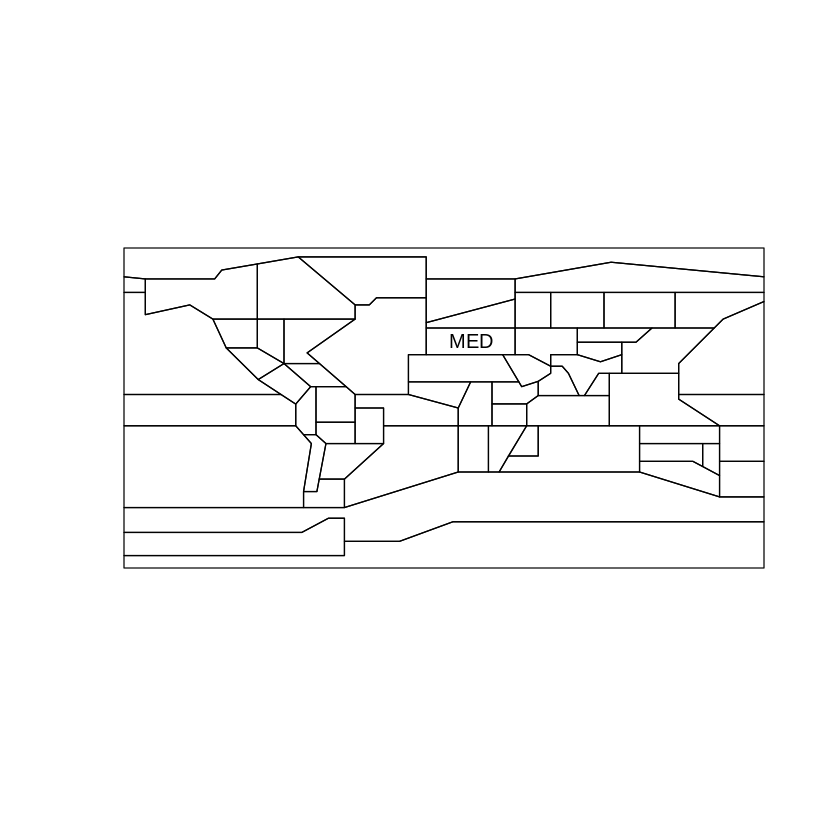

In [3]:
load("../reference-regions/IPCC-WGI-reference-regions-v4_R.rda", verbose = TRUE)
refregions <- as(IPCC_WGI_reference_regions_v4, "SpatialPolygons")
region <- refregions["MED"]
bb <- bbox(region)
lons <- bb[1,] 
lats <- bb[2,]

plot(refregions)
text(x = coordinates(region)[,1],
     y = coordinates(region)[,2],
     labels = names(region), cex = 1)

Region boundaries, extracted with the `bbox` function, will be used next to read the exemplary data.

### Load datasets from the User Data Gateway - Thredds Access Portal (UDG-TAP)
First, we load daily mean temperature for the observations and the model (historical and future scenario), by using their UDG code and the temporal and spatial extents defined above. 

In [5]:
load.data <- function (dset, years, var) loadGridData(dataset = dset, var = var,
                                                 years = years,
                                                 latLim =lats, lonLim=lons,
                                                 season=season) 
y.tas <- load.data(dataset.obs, years.hist, "tas")
x.tas <- load.data(dataset.hist, years.hist, "tas")
newdata.tas <- load.data(dataset.rcp, years.rcp, "tas")

NOTE: Accessing harmonized data from a public UDG dataset

[2021-07-12 09:03:18] Defining harmonization parameters for variable "tas"

[2021-07-12 09:03:18] Opening dataset...

[2021-07-12 09:03:20] The dataset was successfuly opened

[2021-07-12 09:03:20] Defining geo-location parameters

[2021-07-12 09:03:20] Defining time selection parameters

[2021-07-12 09:03:20] Retrieving data subset ...

[2021-07-12 09:04:16] Done

NOTE: Accessing harmonized data from a public UDG dataset

[2021-07-12 09:04:16] Defining harmonization parameters for variable "tas"

[2021-07-12 09:05:35] Opening dataset...

[2021-07-12 09:05:39] The dataset was successfuly opened

[2021-07-12 09:05:39] Defining geo-location parameters

[2021-07-12 09:05:39] Defining time selection parameters

[2021-07-12 09:05:40] Retrieving data subset ...

[2021-07-12 09:06:24] Done

NOTE: Accessing harmonized data from a public UDG dataset

[2021-07-12 09:06:24] Defining harmonization parameters for variable "tas"

[2021-07-12

We can likewise load daily minimum and maximum temperature:

In [6]:
y.tasmin <- load.data(dataset.obs, years.hist, "tasmin")
x.tasmin <- load.data(dataset.hist, years.hist, "tasmin")
newdata.tasmin <- load.data(dataset.rcp, years.rcp, "tasmin")

y.tasmax <- load.data(dataset.obs, years.hist, "tasmax")
x.tasmax <- load.data(dataset.hist, years.hist, "tasmax")
newdata.tasmax <- load.data(dataset.rcp, years.rcp, "tasmax")

NOTE: Accessing harmonized data from a public UDG dataset

[2021-07-12 09:09:21] Defining harmonization parameters for variable "tasmin"

[2021-07-12 09:09:22] Opening dataset...

[2021-07-12 09:09:25] The dataset was successfuly opened

[2021-07-12 09:09:25] Defining geo-location parameters

[2021-07-12 09:09:25] Defining time selection parameters

[2021-07-12 09:09:25] Retrieving data subset ...

[2021-07-12 09:10:24] Done

NOTE: Accessing harmonized data from a public UDG dataset

[2021-07-12 09:10:24] Defining harmonization parameters for variable "tasmin"

[2021-07-12 09:10:24] Opening dataset...

[2021-07-12 09:10:29] The dataset was successfuly opened

[2021-07-12 09:10:29] Defining geo-location parameters

[2021-07-12 09:10:29] Defining time selection parameters

[2021-07-12 09:10:30] Retrieving data subset ...

[2021-07-12 09:11:18] Done

NOTE: Accessing harmonized data from a public UDG dataset

[2021-07-12 09:11:18] Defining harmonization parameters for variable "tasmin"

[2

#### Data preparation
Due to the spatial mismatch between the model and observations, we will upscale the observations from their original grid (0.5$^\circ\times$0.5$^\circ$) to a 1$^\circ\times$1$^\circ$ grid. This way, they are also on a similar resolution to the model (1.125$^\circ$). For a discussion on this procedure, see Casanueva et al. 2020. 

In [7]:
upscale <- function(grid) redim(upscaleGrid(grid, times = 2, aggr.fun = list(FUN="mean", na.rm=TRUE)), drop=TRUE)
y.tas <- upscale(y.tas)
y.tasmax <- upscale(y.tasmax)
y.tasmin <- upscale(y.tasmin)

### Load local datasets

Alternatively, the exemplary datasets are located in the `auxiliary-material` folder:

In [34]:
load("auxiliary-material/W5E5_MED_tas-tasmin-tasmax_1986-2005_JJA.Rdata")
load("auxiliary-material/CMIP5_EC-EARTH_r12i1p1_historical_MED_tas-tasmin-tasmax_1986-2005_JJA.Rdata")
load("auxiliary-material/CMIP5_EC-EARTH_r12i1p1_rcp85_MED_tas-tasmin-tasmax_2041-2060_JJA.Rdata")

### Model biases

We now interpolate the historical model data onto the observations grid with `interpGrid`. **Note:** nearest neighbour interpolation is implicitly performed within bias adjustment when the grids do not match; here it is included to illustrate model biases.

In [35]:
hist.tas <- interpGrid(x.tas, new.coordinates = getGrid(y.tas), method="nearest")

# the same for minimum temperature
hist.tasmin <- interpGrid(x.tasmin, new.coordinates = getGrid(y.tasmin), method="nearest")

# the same for maximum temperature
hist.tasmax <- interpGrid(x.tasmax, new.coordinates = getGrid(y.tasmax), method="nearest")

[2021-07-12 09:57:44] Calculating nearest neighbors...

[2021-07-12 09:57:44] Performing nearest interpolation... may take a while

[2021-07-12 09:57:45] Done

[2021-07-12 09:57:45] Calculating nearest neighbors...

[2021-07-12 09:57:45] Performing nearest interpolation... may take a while

[2021-07-12 09:57:45] Done

[2021-07-12 09:57:45] Calculating nearest neighbors...

[2021-07-12 09:57:45] Performing nearest interpolation... may take a while

[2021-07-12 09:57:45] Done



The following plot illustrates the model biases in the mean temperatures:

[2021-07-12 09:57:48] - Computing climatology...

[2021-07-12 09:57:48] - Done.

[2021-07-12 09:57:48] - Computing climatology...

[2021-07-12 09:57:48] - Done.

[2021-07-12 09:57:48] - Computing climatology...

[2021-07-12 09:57:48] - Done.

[2021-07-12 09:57:48] - Computing climatology...

[2021-07-12 09:57:48] - Done.

[2021-07-12 09:57:48] - Computing climatology...

[2021-07-12 09:57:49] - Done.

[2021-07-12 09:57:49] - Computing climatology...

[2021-07-12 09:57:49] - Done.



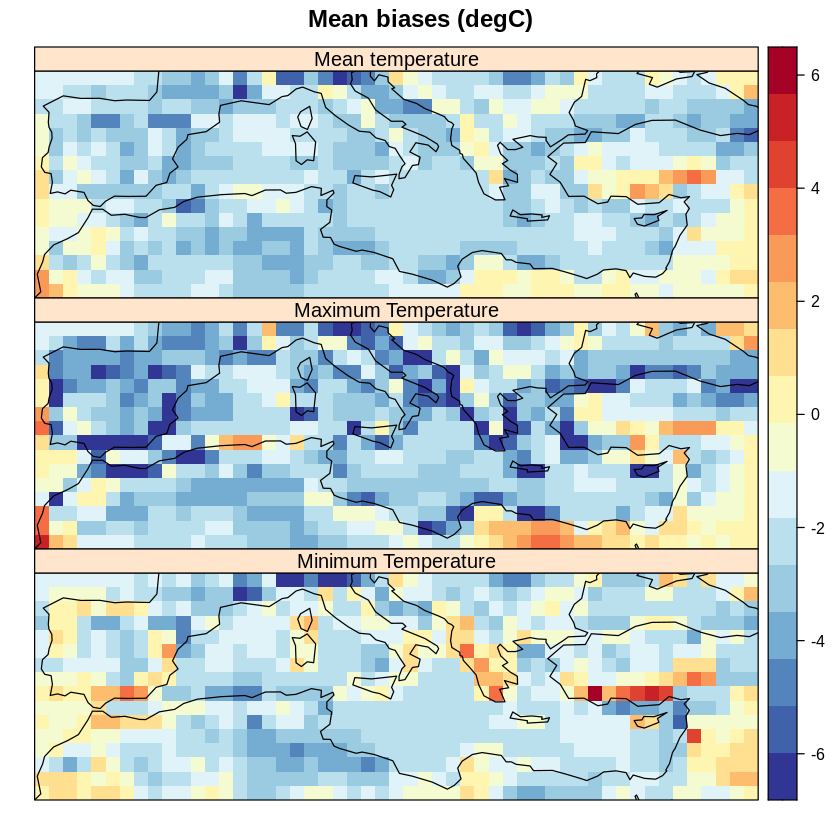

In [36]:
bias.tas <- gridArithmetics(climatology(hist.tas), climatology(y.tas), operator = c("-"))
bias.tasmax <- gridArithmetics(climatology(hist.tasmax), climatology(y.tasmax), operator = c("-"))
bias.tasmin <- gridArithmetics(climatology(hist.tasmin), climatology(y.tasmin), operator = c("-"))

spatialPlot(makeMultiGrid(bias.tas, bias.tasmax, bias.tasmin, skip.temporal.check=TRUE), backdrop.theme="coastline", 
            names.attr=c("Mean temperature","Maximum Temperature","Minimum Temperature"),
            main="Mean biases (degC)", as.table=TRUE, set.min=-6, set.max=6, rev.colors=TRUE)

And annual TX35  (number of days with maximum temperature above 35$^\circ$C), obtained with `indexGrid`:

In [37]:
index.obs <- redim(indexGrid(tx = y.tasmax, index.code = "TXth", th = 35, time.resolution = "year"), drop = TRUE)
index.raw <- redim(indexGrid(tx = hist.tasmax, index.code = "TXth", th = 35, time.resolution = "year"), drop = TRUE)

[2021-07-12 09:57:52] Calculating TXth ...

[2021-07-12 09:57:52] Done

[2021-07-12 09:57:52] Calculating TXth ...

[2021-07-12 09:57:52] Done



Calculate multi-year means with `climatology` and plot the bias:

[2021-07-12 09:57:54] - Computing climatology...

[2021-07-12 09:57:54] - Done.

[2021-07-12 09:57:54] - Computing climatology...

[2021-07-12 09:57:54] - Done.



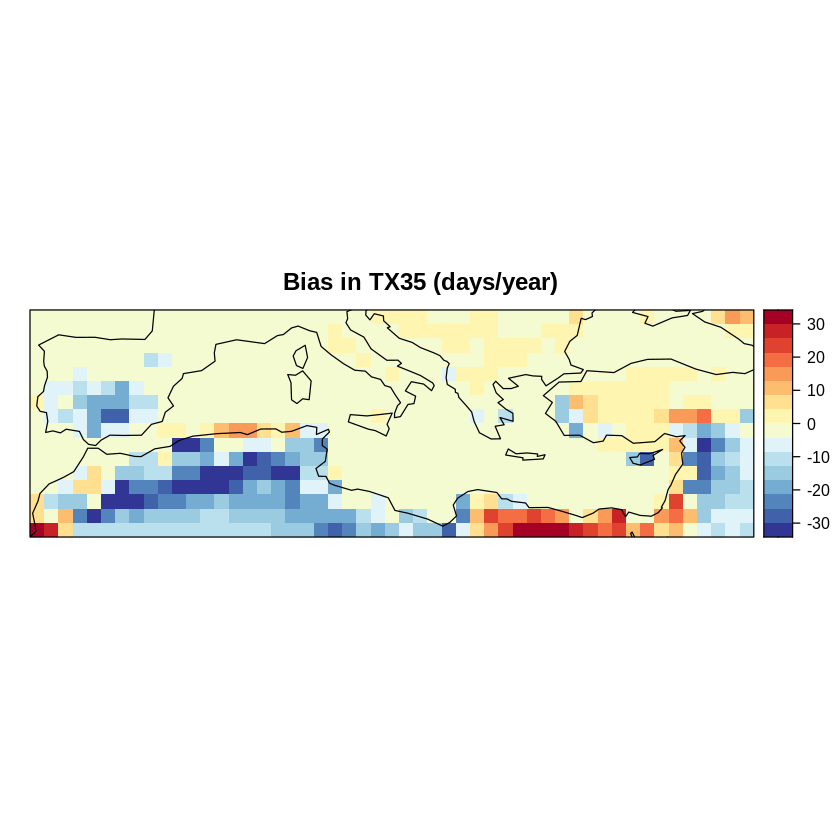

In [38]:
tx35.obs <- climatology(index.obs)
tx35.raw <- climatology(index.raw)
bias.tx35 <- gridArithmetics(tx35.raw, tx35.obs, operator = c("-"))
spatialPlot(bias.tx35, backdrop.theme="coastline", main="Bias in TX35 (days/year)", set.min=-30, set.max=30, rev.colors=TRUE)

### Bias adjustment
Bias adjusment of temperatures with ISIMIP3 consists of three steps: 1) adjustment of daily mean temperature, 2) adjustment of the temperature range and 3) adjustment of the temperature skewness. 

First, we calculate the temperature range and skewness for the observations and (historical and future) simulations, performing simple arithmetics with `GridArithmetics`:

In [39]:
y.range <- gridArithmetics(y.tasmax, y.tasmin, operator = c("-"))
x.range <- gridArithmetics(x.tasmax, x.tasmin, operator = c("-"))
newdata.range <- gridArithmetics(newdata.tasmax,newdata.tasmin, operator = c("-"))
y.skew <- gridArithmetics(gridArithmetics(y.tas, y.tasmin, operator = "-"), y.range, operator = "/")
x.skew <- gridArithmetics(gridArithmetics(x.tas,x.tasmin, operator = "-"), x.range, operator = "/")
newdata.skew <- gridArithmetics(gridArithmetics(newdata.tas, newdata.tasmin, operator = "-"), newdata.range, operator = "/")

Next, we perform bias adjustment of daily mean temperature. Both the future and the historical simulations are adjusted:

In [40]:
isimip3.args = list(lower_bound =  c(NULL),lower_threshold =  c(NULL), upper_bound =  c(NULL), 
                    upper_threshold =  c(NULL),  randomization_seed =  NULL, 
                    detrend =  array(data  =  TRUE, dim = 1), rotation_matrices =  c(NULL), 
                    n_quantiles = 50, distribution =  c("normal"), trend_preservation = array(data  =  "additive", dim = 1), 
                    adjust_p_values = array(data  =  FALSE, dim = 1), if_all_invalid_use =  c(NULL), 
                    invalid_value_warnings = FALSE)

bc.tas <- biasCorrection(y = y.tas, x = x.tas, newdata = newdata.tas, "precipitation" = FALSE, 
                         "isimip3.args" = isimip3.args, "method"="isimip3")

bc.tas.hist <- biasCorrection(y = y.tas, x = x.tas, newdata = x.tas, "precipitation" = FALSE, 
                         "isimip3.args" = isimip3.args, "method"="isimip3")

[2021-07-12 09:58:13] Trying to determine the time zone...

[2021-07-12 09:58:13] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2021-07-12 09:58:14] Trying to determine the time zone...

[2021-07-12 09:58:14] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2021-07-12 09:58:14] Trying to determine the time zone...

[2021-07-12 09:58:14] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2021-07-12 09:58:15] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2021-07-12 09:58:17] Number of windows considered: 1...

[2021-07-12 09:58:17] Bias-correcting 1 members separately...

[2021-07-12 10:00:19] Done.

[2021-07-12 10:00:19] Trying to determine the time zone...

[2021-07-12 10:00:19] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2021-07-12 10:00:19] Trying to determine the time zone.

Bias ajustment of temperature range:

In [41]:
isimip3.range.args  =  list(lower_bound =  c(0), lower_threshold =  c(0.01), upper_bound =  c(NULL), 
                            upper_threshold =  c(NULL), randomization_seed =  NULL, 
                            detrend =  array(data  =  FALSE, dim = 1), rotation_matrices =  c(NULL), 
                            n_quantiles = 50, distribution =  c("rice"), trend_preservation = array(data = "mixed", dim=1),
                            adjust_p_values = array(data  =  FALSE, dim = 1), if_all_invalid_use =  c(NULL), 
                            invalid_value_warnings = FALSE)
bc.range <- biasCorrection(y = y.range, x = x.range, newdata = newdata.range, "precipitation" = FALSE, 
                           "isimip3.args" = isimip3.range.args, "method"="isimip3")

bc.range.hist <- biasCorrection(y = y.range, x = x.range, newdata = x.range, "precipitation" = FALSE, 
                           "isimip3.args" = isimip3.range.args, "method"="isimip3")

[2021-07-12 10:02:27] Trying to determine the time zone...

[2021-07-12 10:02:27] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2021-07-12 10:02:27] Trying to determine the time zone...

[2021-07-12 10:02:27] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2021-07-12 10:02:28] Trying to determine the time zone...

[2021-07-12 10:02:28] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2021-07-12 10:02:29] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2021-07-12 10:02:30] Number of windows considered: 1...

[2021-07-12 10:02:31] Bias-correcting 1 members separately...

[2021-07-12 10:04:19] Done.

[2021-07-12 10:04:19] Trying to determine the time zone...

[2021-07-12 10:04:19] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2021-07-12 10:04:19] Trying to determine the time zone.

And bias adjustment of temperature skewness:

In [42]:
isimip3.skew.args  =  list(lower_bound =  c(0), lower_threshold =  c(0.0001), upper_bound =  c(1), 
                           upper_threshold =  c(0.9999), randomization_seed =  NULL,
                           detrend =  array(data  =  FALSE, dim = 1), rotation_matrices =  c(NULL), 
                           n_quantiles = 50, distribution =  c("beta"), trend_preservation = array(data = "bounded", dim = 1), 
                           adjust_p_values = array(data  =  FALSE, dim = 1), if_all_invalid_use  =  c(NULL),
                           invalid_value_warnings  =  FALSE)
bc.skew <- biasCorrection(y = y.skew, x = x.skew, newdata = newdata.skew, "precipitation" = FALSE, 
                          "isimip3.args" = isimip3.skew.args, "method"="isimip3")

bc.skew.hist <- biasCorrection(y = y.skew, x = x.skew, newdata = x.skew, "precipitation" = FALSE, 
                          "isimip3.args" = isimip3.skew.args, "method"="isimip3")

[2021-07-12 10:06:42] Trying to determine the time zone...

[2021-07-12 10:06:42] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2021-07-12 10:06:43] Trying to determine the time zone...

[2021-07-12 10:06:43] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2021-07-12 10:06:43] Trying to determine the time zone...

[2021-07-12 10:06:43] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2021-07-12 10:06:44] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2021-07-12 10:06:45] Number of windows considered: 1...

[2021-07-12 10:06:46] Bias-correcting 1 members separately...

[2021-07-12 10:08:55] Done.

[2021-07-12 10:08:55] Trying to determine the time zone...

[2021-07-12 10:08:55] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2021-07-12 10:08:55] Trying to determine the time zone.

Bias-adjusted maximum and minimum temperature are reconstructed as follows:

In [43]:
bc.tasmin <- gridArithmetics(bc.tas, gridArithmetics(bc.range, bc.skew, operator = c("*")), operator = c("-"))
bc.tasmax <- gridArithmetics(bc.tasmin, bc.range, operator = c("+"))

# the same for the bias-adjusted historical simulations
bc.tasmin.hist <- gridArithmetics(bc.tas.hist, gridArithmetics(bc.range.hist, bc.skew.hist, operator = c("*")), operator = c("-"))
bc.tasmax.hist <- gridArithmetics(bc.tasmin.hist, bc.range.hist, operator = c("+"))

### Calculation of extreme temperature indices
Daily maximum temperature is used to obtain historical and future TX35, using `indexGrid`. 

In [44]:
index.rcp <- redim(indexGrid(tx = bc.tasmax, index.code = "TXth", th = 35, time.resolution = "year"), drop = TRUE)
index.hist <- redim(indexGrid(tx = bc.tasmax.hist, index.code = "TXth", th = 35, time.resolution = "year"), drop = TRUE)

[2021-07-12 10:15:52] Calculating TXth ...

[2021-07-12 10:15:52] Done

[2021-07-12 10:15:52] Calculating TXth ...

[2021-07-12 10:15:52] Done



Multi-year means are calculated with `climatology`:

In [45]:
tx35.hist <- climatology(index.hist)
tx35.rcp <- climatology(index.rcp)

[2021-07-12 10:16:10] - Computing climatology...

[2021-07-12 10:16:10] - Done.

[2021-07-12 10:16:10] - Computing climatology...

[2021-07-12 10:16:10] - Done.



And finally we plot the results for the historical and future TX35:

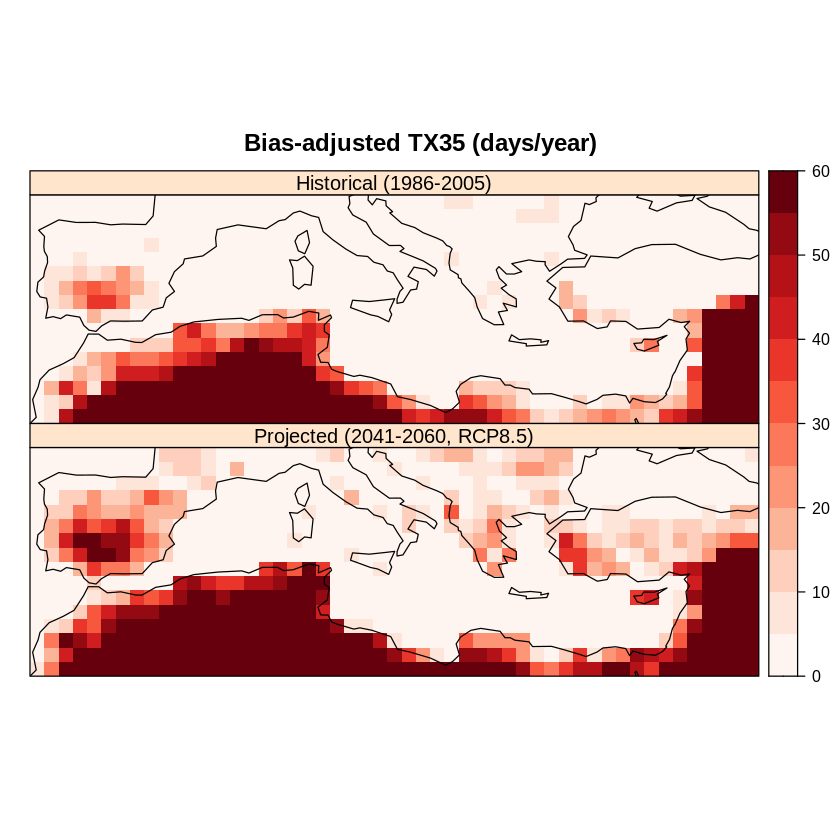

In [46]:
spatialPlot(makeMultiGrid(tx35.hist, tx35.rcp, skip.temporal.check=TRUE), backdrop.theme="coastline", 
            color.them="Reds", names.attr=c("Historical (1986-2005)","Projected (2041-2060, RCP8.5)"),
            main="Bias-adjusted TX35 (days/year)", as.table=TRUE, set.max=60, at=seq(0,60,5))

### Session Information

In [47]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/ana/Appz/miniconda3/envs/notebooks-atlas/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=es_ES.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=es_ES.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=es_ES.UTF-8          LC_NAME=es_ES.UTF-8          
 [9] LC_ADDRESS=es_ES.UTF-8        LC_TELEPHONE=es_ES.UTF-8     
[11] LC_MEASUREMENT=es_ES.UTF-8    LC_IDENTIFICATION=es_ES.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rgdal_1.5-16            sp_1.4-5                visualizeR_1.6.0       
 [4] climate4R.indices_0.1.0 downscaleR_3.3.2        transformeR_2.1.2      
 [7] loadeR_1.7.0            climate4R.UDG_0.2.3     loadeR.java_1.1.1      
[10] rJava_1.0-4          

### References

* Bedia, J., Baño-Medina, J., Legasa, M.N., Iturbide, M., Manzanas, R., Herrera, S., Casanueva, A., San-Martín, D., Cofiño, A.S. and Gutiérrez, J.M. (2020) Statistical downscaling with the downscaleR package (v3.1.0): contribution to the VALUE intercomparison experiment. Geoscientific Model Developmen, 13, 1711–1735.
https://doi.org/10.5194/gmd-13-1711-2020.
* Bivand R.S., Keitt T., Rowlingson B. (2018). rgdal: Bindings for the ‘Geospatial’ Data Abstraction Library. R package version 1.3-6. https://CRAN.R-project.org/package=rgdal
*  Casanueva, A, Herrera, S, Iturbide, M, et al. (2020) Testing bias adjustment methods for regional climate change applications under observational uncertainty and resolution mismatch. Atmos Sci Lett. 21: 21:e978. https://doi.org/10.1002/asl.978
* Cucchi, M.,Weedon, G. P., Amici, A., Bellouin, N., Lange, S., Schmied, H. M., Hersbach, H. and Buontempo, C. (2020) WFDE5: bias-adjusted ERA5 reanalysis data for impact studies. Earth System Science Data, 12, 2097–2120,  https://doi.org/10.5194/essd-12-2097-2020.
* Frías, M.D., Iturbide, M., Manzanas, R., Bedia, J., Fernández, J., Herrera, S., Cofiño, A.S., Gutiérrez, J.M. (2018). An R package to visualize and communicate uncertainty in seasonal climate prediction. Environ. Model. Software 99, 101–110. https://doi.org/10.1016/j.envsoft.2017.09.008.
* Iturbide, M., Bedia, J., Herrera, S., Baño-Medina, J., Fernández, J., Frías, M. D., Manzanas, R., San-Martín, D., Cimadevilla, E., Cofiño, A. S., and Gutiérrez, J. M. (2019) The R-based climate4R open framework for reproducible climate data access and post-processing, Environ. Modell. Softw., 111, 42–54,
https://doi.org/10.1016/j.envsoft.2018.09.009.
* Iturbide, M., Gutiérrez, J. M., Alves, L. M., Bedia, J., Cerezo-Mota, R., Cimadevilla, E., Cofiño, A. S., Di Luca, A., Faria, S. H., Gorodetskaya, I. V., Hauser, M., Herrera, S., Hennessy, K., Hewitt, H. T., Jones, R. G., Krakovska, S., Manzanas, R., Martínez-Castro, D., Narisma, G. T., Nurhati, I. S., Pinto, I., Seneviratne, S. I., van den Hurk, B., and Vera, C. S. (2020) An update of IPCC climate reference regions for subcontinental analysis of climate model data: definition and aggregated datasets, Earth Syst. Sci. Data, 12, 2959–2970, https://doi.org/10.5194/essd-12-2959-2020. 
* Lange, S. (2019) Trend-preserving bias adjustment and statistical downscaling with ISIMIP3BASD (v1.0). Geoscientific Model Development, 12, 3055–3070. https://doi.org/10.5194/gmd-12-3055-2019.
